In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from functools import partial

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0
x_train = np.reshape(x_train, (-1, 28*28))
x_test = np.reshape(x_test, (-1, 28*28))

print("train shape:", x_train.shape, "\ntest shape:", x_test.shape)

train shape: (60000, 784) 
test shape: (10000, 784)


In [3]:
def plot_reconstructed_image(noisy_digit, digit_reconstructed):
    fig = plt.figure(1, figsize=(6, 6))

    axis = fig.add_subplot(1, 2, 1)
    arr = np.reshape(noisy_digit, (28, 28))
    axis.imshow(arr, cmap='gray')
    axis.set(title='noisy')

    axis = fig.add_subplot(1, 2, 2)
    arr = np.reshape(digit_reconstructed, (28, 28))
    axis.imshow(arr, cmap='gray')
    axis.set(title='reconstructed')

    plt.show()


def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

## Denoising autoencoder 

In [4]:
# autoencoder with dence layers
tf.reset_default_graph()

dropout_rate = 0.3
n_inputs = 28*28
n_encoder_hidden1 = n_inputs
n_encoder_hidden2 = n_inputs
n_coding_layer = n_inputs
n_decoder_hidden1 = n_encoder_hidden2
n_decoder_hidden2 = n_encoder_hidden1
n_outputs = n_inputs

training = tf.placeholder_with_default(False, shape=())
learning_rate = tf.placeholder_with_default(1e-3, shape=())

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

he_init = tf.contrib.layers.variance_scaling_initializer()
my_dence_layer = partial(tf.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=he_init)

encoder_hidden1 = my_dence_layer(X_drop, n_encoder_hidden1)
encoder_hidden2 = my_dence_layer(encoder_hidden1, n_encoder_hidden2)
coding_layer = my_dence_layer(encoder_hidden2, n_coding_layer)
decoder_hidden1 = my_dence_layer(coding_layer, n_decoder_hidden1)
decoder_hidden2 = my_dence_layer(decoder_hidden1, n_decoder_hidden2)
outputs = my_dence_layer(decoder_hidden2, n_outputs, activation=tf.nn.sigmoid)

loss = tf.reduce_mean(tf.square(outputs - X))  # MSE loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

epoch 0 	 train loss: 0.009785725 	 test loss: 0.009692614


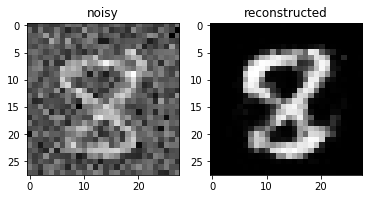

epoch 1 	 train loss: 0.00812644 	 test loss: 0.008139597
epoch 2 	 train loss: 0.006771843 	 test loss: 0.006875315
epoch 3 	 train loss: 0.006148406 	 test loss: 0.0063110422


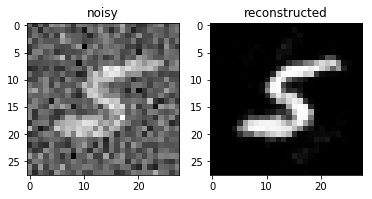

epoch 4 	 train loss: 0.0063944 	 test loss: 0.0066265385
epoch 5 	 train loss: 0.005893565 	 test loss: 0.0061563277
epoch 6 	 train loss: 0.0058948155 	 test loss: 0.0062045394


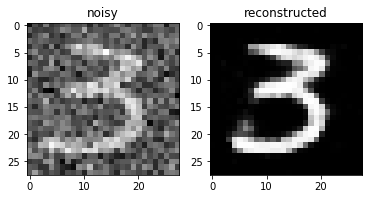

epoch 7 	 train loss: 0.006251042 	 test loss: 0.006637015
epoch 8 	 train loss: 0.0054816133 	 test loss: 0.00587301
epoch 9 	 train loss: 0.005219899 	 test loss: 0.005628609


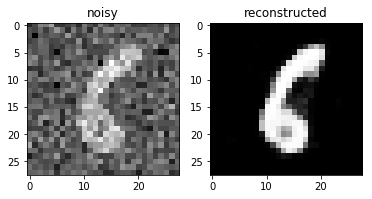

In [8]:
n_epochs = 10
batch_size = 256
x_batches = np.array_split(x_train, len(x_train) // batch_size)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for x_batch in x_batches:
            sess.run(training_op, feed_dict={X: x_batch, training: True})
        train_loss = loss.eval(feed_dict={X: x_train})
        test_loss = loss.eval(feed_dict={X: x_test})

        print("epoch", epoch, "\t train loss:", train_loss, "\t test loss:", test_loss)
        if (epoch % 3) == 0:  # show reconstructed image every 3th epoch
            one_digit = x_test[np.random.randint(x_test.shape[0])]
            one_digit = np.reshape(one_digit, (1, -1)) + np.random.normal(size=one_digit.shape)*0.3
            one_digit_reconstructed = outputs.eval(feed_dict={X: one_digit})
            plot_reconstructed_image(one_digit, one_digit_reconstructed)
    saver.save(sess, "./denoising_autoencoder/denoising_model")

In [13]:
sess = tf.InteractiveSession()
saver = tf.train.import_meta_graph('./denoising_autoencoder/denoising_model.meta')
saver.restore(sess, tf.train.latest_checkpoint('./denoising_autoencoder/'))

INFO:tensorflow:Restoring parameters from ./denoising_autoencoder/denoising_model


In [20]:
from ipywidgets import interactive

# reconstruct arbitrary image


def reconstruct(noise=(0, 1, 0.05), image_idx=(0, 100, 1)):
    one_digit = x_test[image_idx]
    one_digit = np.reshape(one_digit, (1, -1)) + \
        np.random.normal(size=one_digit.shape)*noise
    one_digit_reconstructed = outputs.eval(feed_dict={X: one_digit})
    plot_reconstructed_image(one_digit, one_digit_reconstructed)


interactive(reconstruct)

interactive(children=(FloatSlider(value=0.0, description='noise', max=1.0, step=0.05), IntSlider(value=50, des…

In [21]:
sess.close()

## Generative autoencoder

In [23]:
tf.reset_default_graph()

n_inputs = 28*28
n_encoder_hidden1 = 500
n_encoder_hidden2 = 500
n_coding_layer = 50
n_decoder_hidden1 = n_encoder_hidden2
n_decoder_hidden2 = n_encoder_hidden1
n_outputs = n_inputs

learning_rate = tf.placeholder_with_default(1e-3, shape=())

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.contrib.layers.variance_scaling_initializer()
my_dence_layer = partial(tf.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=he_init)

encoder_hidden1 = my_dence_layer(X, n_encoder_hidden1)
encoder_hidden2 = my_dence_layer(encoder_hidden1, n_encoder_hidden2)

# During the training we're trying to find right parameters mean and gamma
# To generate images, we will sample from this distribution by inputting noise
coding_layer_mean = my_dence_layer(encoder_hidden2, n_coding_layer, activation=None)
coding_layer_gamma = my_dence_layer(encoder_hidden2, n_coding_layer, activation=None)
noise = tf.random_normal(tf.shape(coding_layer_gamma), dtype=tf.float32)
coding_layer = coding_layer_mean + tf.exp(0.5*coding_layer_gamma)*noise

decoder_hidden1 = my_dence_layer(coding_layer, n_decoder_hidden1)
decoder_hidden2 = my_dence_layer(decoder_hidden1, n_decoder_hidden2)
logits = my_dence_layer(decoder_hidden2, n_outputs, activation=None)
outputs = tf.nn.sigmoid(logits)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)

reconstruction_loss = tf.reduce_sum(xentropy)
latent_loss = 0.5 * tf.reduce_sum(tf.exp(coding_layer_gamma) + tf.square(coding_layer_mean) - 1 - coding_layer_gamma)
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

epoch 0 	 train loss: 8056509.5 	 test loss: 1334959.5


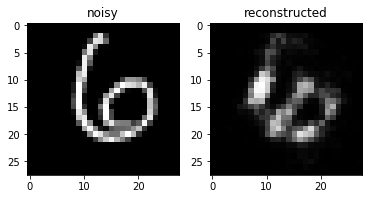

epoch 1 	 train loss: 7429160.0 	 test loss: 1230294.2
epoch 2 	 train loss: 7116400.0 	 test loss: 1180239.5
epoch 3 	 train loss: 6981465.5 	 test loss: 1156854.0
epoch 4 	 train loss: 6839312.0 	 test loss: 1133946.0
epoch 5 	 train loss: 6739882.0 	 test loss: 1118222.1
epoch 6 	 train loss: 6706221.0 	 test loss: 1113660.4
epoch 7 	 train loss: 6598074.5 	 test loss: 1096678.2
epoch 8 	 train loss: 6544304.0 	 test loss: 1086952.0
epoch 9 	 train loss: 6526777.0 	 test loss: 1084414.5
epoch 10 	 train loss: 6460171.0 	 test loss: 1073935.5


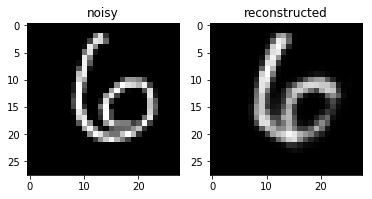

epoch 11 	 train loss: 6410010.0 	 test loss: 1065365.2
epoch 12 	 train loss: 6440305.0 	 test loss: 1071340.8
epoch 13 	 train loss: 6372172.0 	 test loss: 1059516.5
epoch 14 	 train loss: 6352808.5 	 test loss: 1058436.1
epoch 15 	 train loss: 6316287.0 	 test loss: 1050796.8
epoch 16 	 train loss: 6358690.5 	 test loss: 1059452.8
epoch 17 	 train loss: 6313072.0 	 test loss: 1052341.2
epoch 18 	 train loss: 6270166.5 	 test loss: 1045520.2
epoch 19 	 train loss: 6273640.0 	 test loss: 1045121.4
epoch 20 	 train loss: 6263181.0 	 test loss: 1045151.0


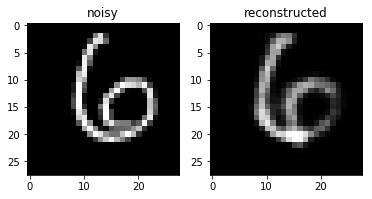

epoch 21 	 train loss: 6277066.0 	 test loss: 1047462.75
epoch 22 	 train loss: 6186307.5 	 test loss: 1030957.56
epoch 23 	 train loss: 6173257.5 	 test loss: 1029901.1
epoch 24 	 train loss: 6195071.0 	 test loss: 1033652.4
epoch 25 	 train loss: 6195518.0 	 test loss: 1033885.1
epoch 26 	 train loss: 6176289.0 	 test loss: 1031994.1
epoch 27 	 train loss: 6134648.0 	 test loss: 1024401.7
epoch 28 	 train loss: 6107950.0 	 test loss: 1018529.5
epoch 29 	 train loss: 6159311.5 	 test loss: 1029169.5
epoch 30 	 train loss: 6143201.0 	 test loss: 1027661.1


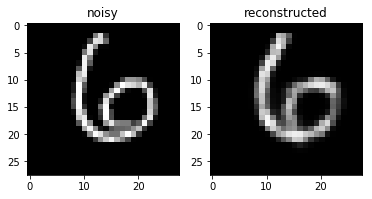

epoch 31 	 train loss: 6112899.0 	 test loss: 1021248.9
epoch 32 	 train loss: 6092891.5 	 test loss: 1017905.6
epoch 33 	 train loss: 6194114.0 	 test loss: 1037734.0
epoch 34 	 train loss: 6080796.0 	 test loss: 1017019.1
epoch 35 	 train loss: 6080940.0 	 test loss: 1017763.9
epoch 36 	 train loss: 6171667.0 	 test loss: 1032965.5
epoch 37 	 train loss: 6170838.5 	 test loss: 1033526.8
epoch 38 	 train loss: 6046453.0 	 test loss: 1012343.0
epoch 39 	 train loss: 6041377.0 	 test loss: 1011458.4
epoch 40 	 train loss: 6064649.5 	 test loss: 1015398.4


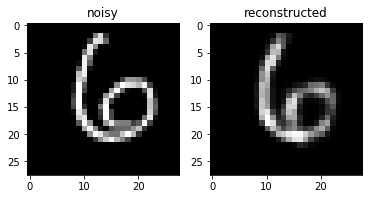

epoch 41 	 train loss: 6051823.0 	 test loss: 1013120.9
epoch 42 	 train loss: 6022138.5 	 test loss: 1007670.6
epoch 43 	 train loss: 6011575.0 	 test loss: 1006466.6
epoch 44 	 train loss: 6006037.0 	 test loss: 1005790.7
epoch 45 	 train loss: 5987678.5 	 test loss: 1004163.75
epoch 46 	 train loss: 5975065.0 	 test loss: 1002415.94
epoch 47 	 train loss: 6013710.5 	 test loss: 1008234.6
epoch 48 	 train loss: 6004697.0 	 test loss: 1006743.0
epoch 49 	 train loss: 5995801.5 	 test loss: 1006325.7


In [25]:
n_epochs = 50
batch_size = 256
x_batches = np.array_split(x_train, len(x_train) // batch_size)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for x_batch in x_batches:
            sess.run(training_op, feed_dict={X: x_batch})
        train_loss = loss.eval(feed_dict={X: x_train})
        test_loss = loss.eval(feed_dict={X: x_test})

        print("epoch", epoch, "\t train loss:", train_loss, "\t test loss:", test_loss)

        if (epoch % 10) == 0:
            #one_digit = x_test[np.random.randint(x_test.shape[0])]
            one_digit = x_test[100]
            one_digit = np.reshape(one_digit, (1, -1))
            one_digit_reconstructed = outputs.eval(feed_dict={X: one_digit})
            plot_reconstructed_image(one_digit, one_digit_reconstructed)
    saver.save(sess, "./generative_autoencoder/generative_model")

In [26]:
# generate images
n_digits = 60
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('./generative_autoencoder/generative_model.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./generative_autoencoder/'))
    codings_rnd = np.random.normal(size=[n_digits, n_coding_layer])
    outputs_val = outputs.eval(feed_dict={coding_layer: codings_rnd})

INFO:tensorflow:Restoring parameters from ./generative_autoencoder/generative_model


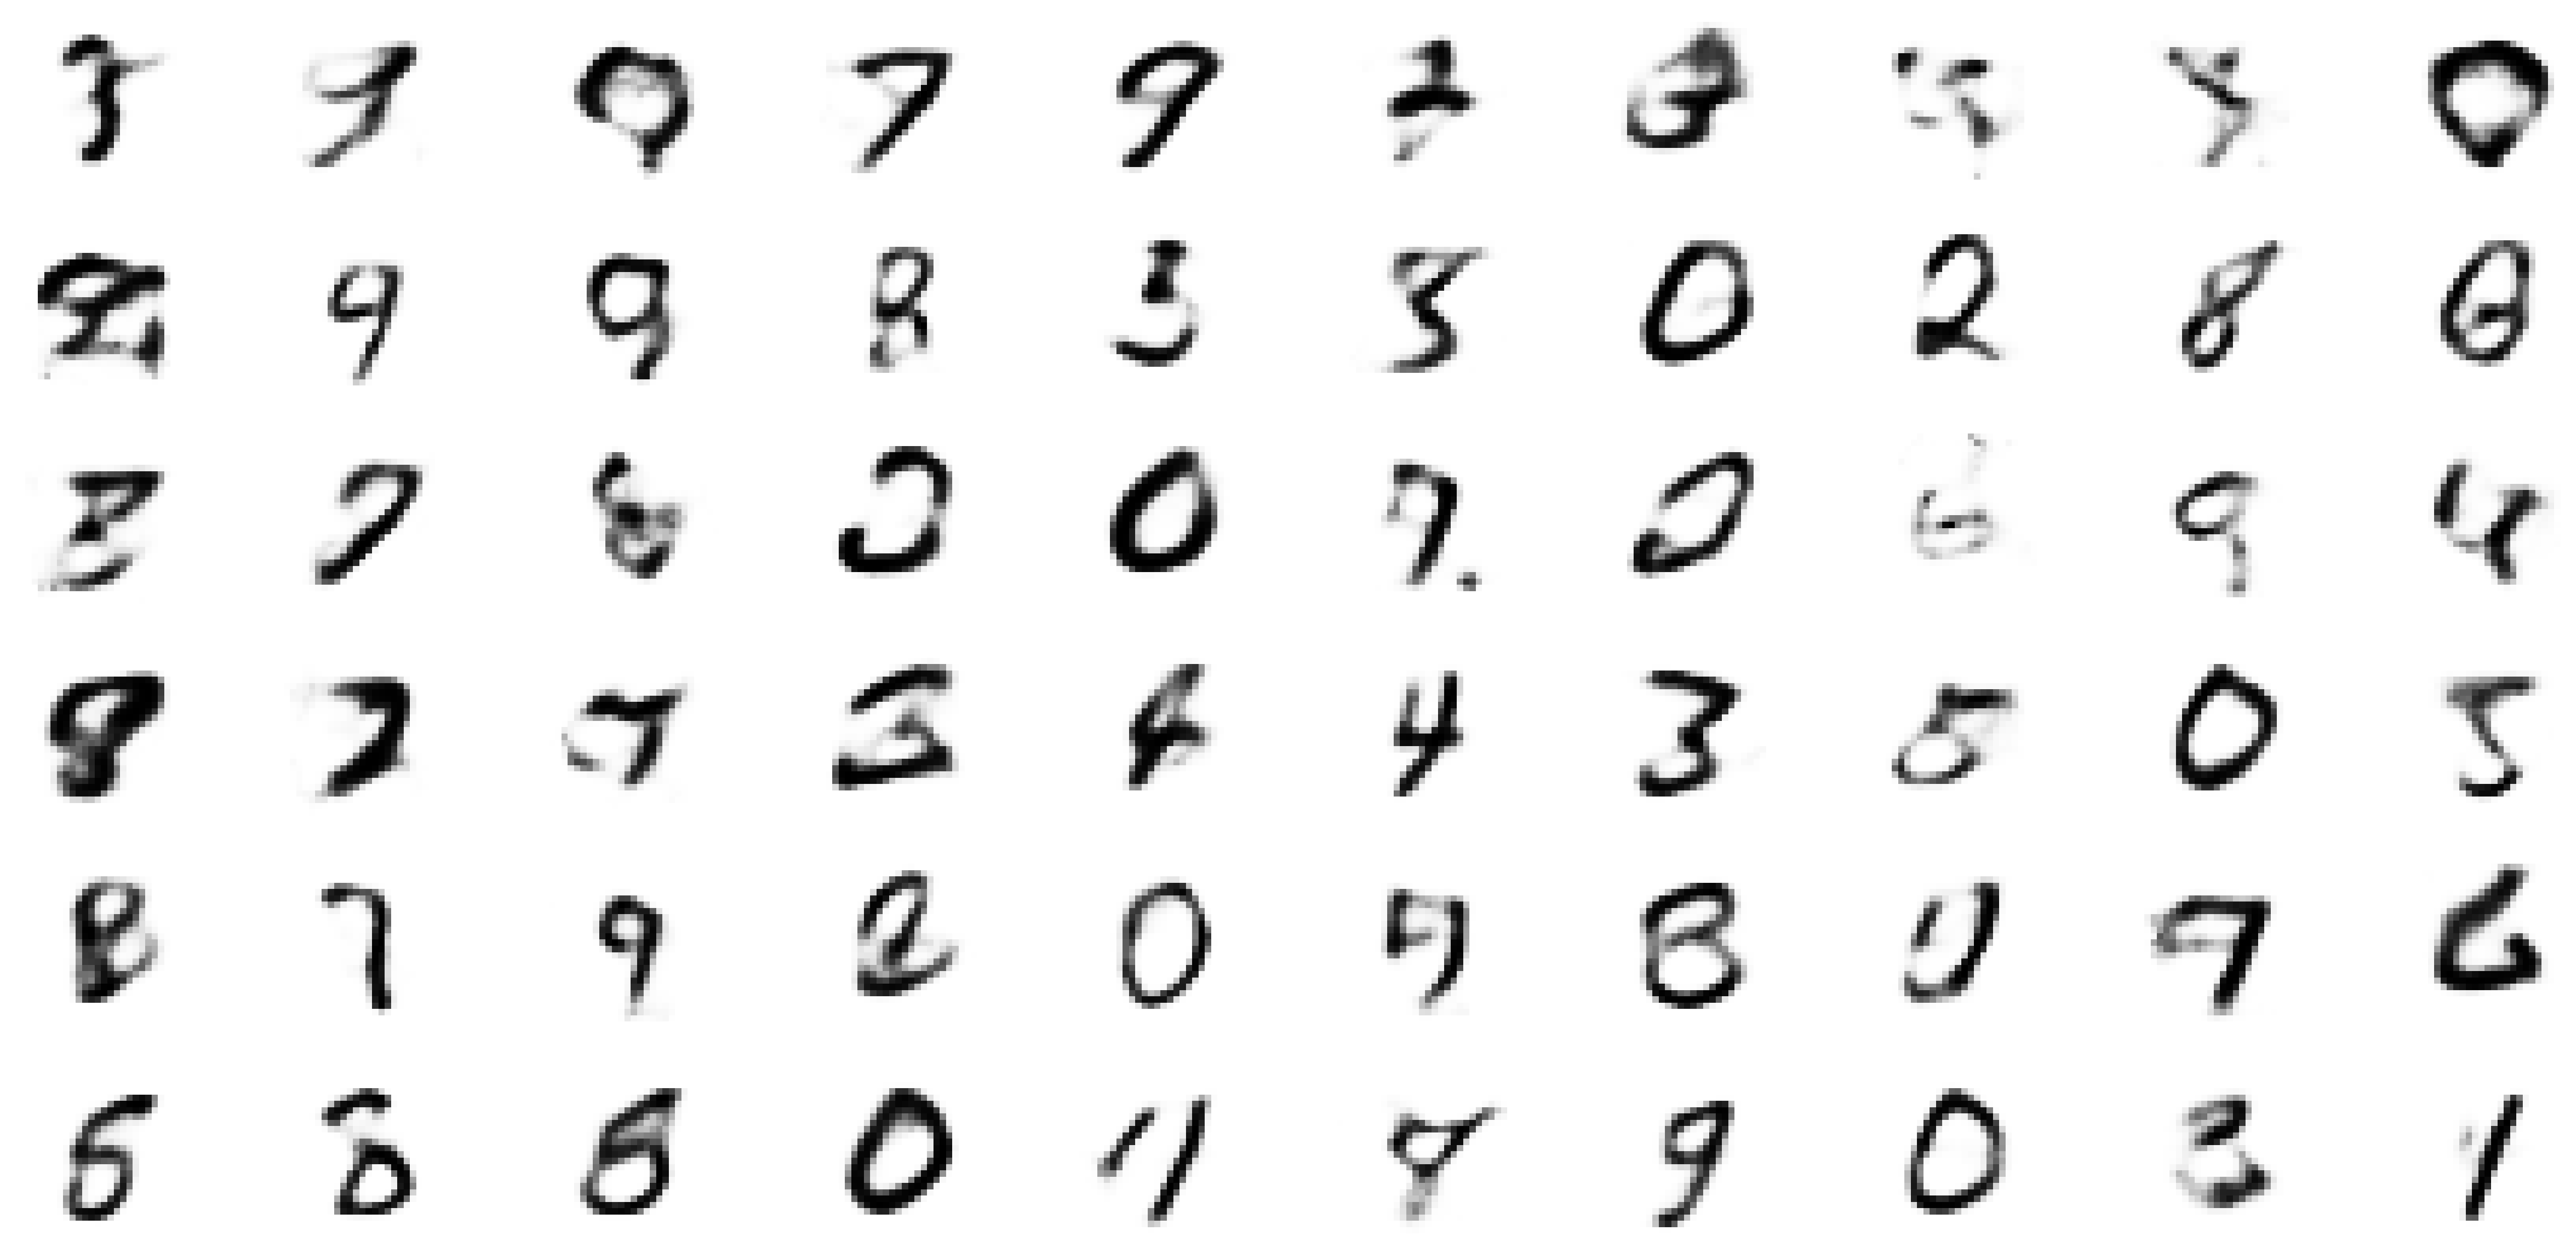

In [27]:
plt.figure(figsize=(100, 500))
for i in range(n_digits):
    plt.subplot(n_digits, 10, i+1)
    plot_image(outputs_val[i])